# Data

In [20]:
# Libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve


In [9]:
# import data

dataset = pd.read_csv('Cleaned-Bank.csv')

In [10]:
dataset

,Age,Job,Marital,Education,Default,Balance,Housing,Loan,Contact,Day,Month,Duration,Campaign,Pdays,Previous,Poutcome,Y
0,30,Unemployed,Married,Primary,No,1787,No,No,Cellular,19,Oct,79,1,-1,0,Unknown,No
1,33,Services,Married,Secondary,No,4789,Yes,Yes,Cellular,11,May,220,1,339,4,Failure,No
2,35,Management,Single,Tertiary,No,1350,Yes,No,Cellular,16,Apr,185,1,330,1,Failure,No
3,30,Management,Married,Tertiary,No,1476,Yes,Yes,Unknown,3,Jun,199,4,-1,0,Unknown,No
4,59,Blue-collar,Married,Secondary,No,0,Yes,No,Unknown,5,May,226,1,-1,0,Unknown,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,Services,Married,Secondary,No,-333,Yes,No,Cellular,30,Jul,329,5,-1,0,Unknown,No
4517,57,Self-employed,Married,Tertiary,Yes,-3313,Yes,Yes,Unknown,9,May,153,1,-1,0,Unknown,No
4518,57,Technician,Married,Secondary,No,295,No,No,Cellular,19,Aug,151,11,-1,0,Unknown,No
4519,28,Blue-collar,Married,Secondary,No,1137,No,No,Cellular,6,Feb,129,4,211,3,Other,No


In [11]:
# selected a set of features

selected_features = ['Age', 'Balance', 'Pdays', 'Poutcome', 'Housing', 'Marital', 'Education', 'Month', 'Contact']  # replace with your actual features
target_column = 'Y'

# Creating a new variable for modeling
model_data = dataset[selected_features + [target_column]].copy()

In [12]:
model_data

,Age,Balance,Pdays,Poutcome,Housing,Marital,Education,Month,Contact,Y
0,30,1787,-1,Unknown,No,Married,Primary,Oct,Cellular,No
1,33,4789,339,Failure,Yes,Married,Secondary,May,Cellular,No
2,35,1350,330,Failure,Yes,Single,Tertiary,Apr,Cellular,No
3,30,1476,-1,Unknown,Yes,Married,Tertiary,Jun,Unknown,No
4,59,0,-1,Unknown,Yes,Married,Secondary,May,Unknown,No
...,...,...,...,...,...,...,...,...,...,...
4516,33,-333,-1,Unknown,Yes,Married,Secondary,Jul,Cellular,No
4517,57,-3313,-1,Unknown,Yes,Married,Tertiary,May,Unknown,No
4518,57,295,-1,Unknown,No,Married,Secondary,Aug,Cellular,No
4519,28,1137,211,Other,No,Married,Secondary,Feb,Cellular,No


In [13]:
# encoding

# Step 2a: One-hot encoding
model_data = pd.get_dummies(model_data, columns=['Poutcome', 'Housing', 'Marital', 'Contact'], drop_first=True)

# Step 2b: Ordinal encoding for Education
education_order = {'Unknown': 0, 'Primary': 1, 'Secondary': 2, 'Tertiary': 3}
model_data['Education'] = model_data['Education'].map(education_order)

# Step 2c: Frequency encoding for Month
month_freq = model_data['Month'].value_counts(normalize=True)
model_data['Month'] = model_data['Month'].map(month_freq)

model_data['Y'] = model_data['Y'].map({'Yes': 1, 'No': 0})

In [15]:
# Step 1: Define Features and Target
X = model_data.drop('Y', axis=1)
y = model_data['Y']

# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Step 3: Apply SMOTE on training set
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# The Model

In [21]:

# 3. Define models
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

best_rf = RandomForestClassifier(
    class_weight='balanced',
    max_depth=None,
    min_samples_split=2,
    n_estimators=200,
    random_state=42
)

xgb_clf = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=7,  # Adjusted for imbalance
    random_state=42
)

# 4. Create the ensemble model
ensemble_clf = VotingClassifier(
    estimators=[('lr', log_reg), ('rf', best_rf), ('xgb', xgb_clf)],
    voting='soft'
)

# 5. Train the ensemble model
ensemble_clf.fit(X_train_bal, y_train_bal)

# 6. Evaluation
y_pred = ensemble_clf.predict(X_test)
y_proba = ensemble_clf.predict_proba(X_test)[:, 1]


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:52:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [22]:
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))


Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91       801
           1       0.33      0.34      0.33       104

    accuracy                           0.85       905
   macro avg       0.62      0.62      0.62       905
weighted avg       0.85      0.85      0.85       905

Confusion Matrix:
 [[731  70]
 [ 69  35]]
ROC AUC Score: 0.6899608662249113


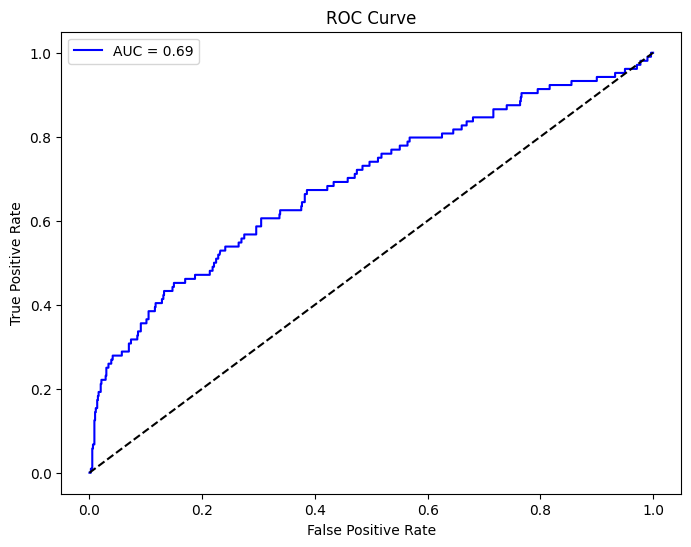

In [23]:
# Optional: ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.2f}", color='blue')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [25]:
# hyperparametr tuning

from sklearn.model_selection import GridSearchCV

# Define weight options for each model
param_grid = {
    'weights': [
        [1, 1, 1],  # equal weight
        [1, 2, 2],  # RF & XGB more weight
        [2, 1, 2],  # LR & XGB more weight
        [2, 2, 1],  # LR & RF more weight
        [1, 1, 3],  # XGB dominant
    ]
}


In [26]:
# Grid search
grid = GridSearchCV(ensemble_clf, param_grid, scoring='f1', cv=5, n_jobs=-1)
grid.fit(X_train_bal, y_train_bal)

# Best ensemble
best_ensemble = grid.best_estimator_

print("Best Ensemble Weights:", grid.best_params_['weights'])

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best Ensemble Weights: [1, 2, 2]


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:08:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [27]:
# threshold tuning

import numpy as np
from sklearn.metrics import f1_score

# Predict probabilities using best ensemble
y_proba_test = best_ensemble.predict_proba(X_test)[:, 1]

# Try thresholds from 0.1 to 0.9
thresholds = np.arange(0.1, 0.91, 0.05)
f1_scores = []

for thresh in thresholds:
    preds = (y_proba_test >= thresh).astype(int)
    score = f1_score(y_test, preds)
    f1_scores.append(score)

# Find best threshold
best_thresh = thresholds[np.argmax(f1_scores)]
print(f"Best Threshold: {best_thresh:.2f}")
print(f"F1 Score at Best Threshold: {max(f1_scores):.4f}")

Best Threshold: 0.60
F1 Score at Best Threshold: 0.3509


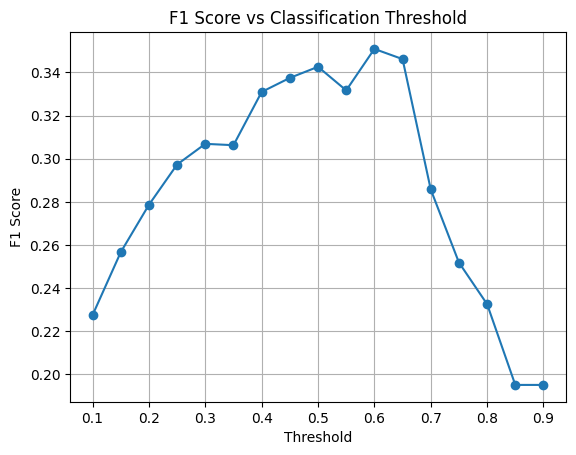

In [29]:
import matplotlib.pyplot as plt

plt.plot(thresholds, f1_scores, marker='o')
plt.title("F1 Score vs Classification Threshold")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.grid(True)
plt.show()


In [31]:
# calibrating the probabilities:

from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold

# Calibrate the best ensemble
calibrator = CalibratedClassifierCV(estimator=best_ensemble, cv=StratifiedKFold(5), method='sigmoid')
calibrator.fit(X_train_bal, y_train_bal)

# Predict calibrated probabilities
calib_probs = calibrator.predict_proba(X_test)[:, 1]

# Tune threshold again using calibrated probs
import numpy as np
from sklearn.metrics import f1_score

thresholds = np.arange(0.1, 0.91, 0.05)
f1_scores = []

for thresh in thresholds:
    preds = (calib_probs >= thresh).astype(int)
    score = f1_score(y_test, preds)
    f1_scores.append(score)

# Best threshold after calibration
best_thresh_calib = thresholds[np.argmax(f1_scores)]
print(f"Best Calibrated Threshold: {best_thresh_calib:.2f}")
print(f"F1 Score at Best Calibrated Threshold: {max(f1_scores):.4f}")



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:21:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-

Best Calibrated Threshold: 0.25
F1 Score at Best Calibrated Threshold: 0.3571


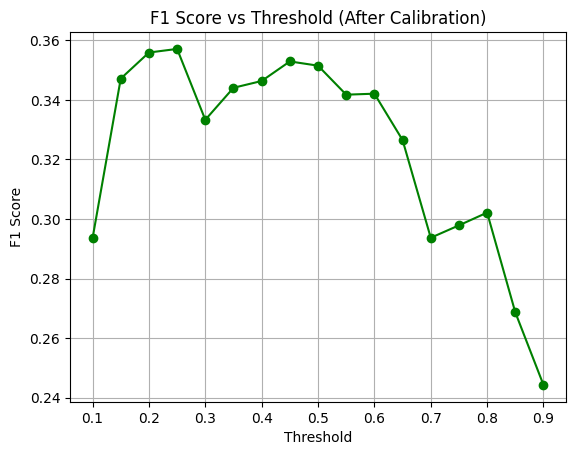

In [32]:
import matplotlib.pyplot as plt

plt.plot(thresholds, f1_scores, marker='o', color='green')
plt.title("F1 Score vs Threshold (After Calibration)")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.grid(True)
plt.show()


In [33]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

final_preds = (calib_probs >= best_thresh_calib).astype(int)

print("Classification Report:\n", classification_report(y_test, final_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, final_preds))
print("Calibrated ROC AUC Score:", roc_auc_score(y_test, calib_probs))


Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.90      0.91       801
           1       0.33      0.38      0.36       104

    accuracy                           0.84       905
   macro avg       0.63      0.64      0.63       905
weighted avg       0.85      0.84      0.85       905

Confusion Matrix:
 [[721  80]
 [ 64  40]]
Calibrated ROC AUC Score: 0.6684012772495918


#Feature Engineering Section

# Model Training with new Features

# Model Eval with new Features